# Obs.: Caso o senhor veja a necessidade de executar o código, recomendo que o faça por sessões, visto que uso o mesmo conjunto para várias coisas, existe a necessidade de resetar alguns dados por sessão. Sempre executando claro, a sessão 1 de tratamento dos dados.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/heart.csv', header = 0)

# Seção 1: Tratando a base de dados

In [3]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [4]:
def normalization(train, test):
  min = train.min()
  max = train.max()

  train = (train-min)/(max-min)
  test = (test-min)/(max-min)

  return train, test

In [5]:
x = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]
dataset

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [6]:
ord = OrdinalEncoder()

ord.fit(x[['Sex']])
x['Sex'] = ord.transform(x[['Sex']])

ord.fit(x[['ExerciseAngina']])
x['ExerciseAngina'] = ord.transform(x[['ExerciseAngina']])

In [7]:
henc = OneHotEncoder()

h_encoder = henc.fit_transform(x[['ChestPainType']])
x = x.join(pd.DataFrame(h_encoder.toarray()))
x = x.drop('ChestPainType', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


In [8]:
h_encoder = henc.fit_transform(x[['RestingECG']])
colunas = ['RestingECG1', 'RestingECG2', 'RestingECG3']
x = x.join(pd.DataFrame(h_encoder.toarray(), columns = colunas))
x = x.drop('RestingECG', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [9]:
h_encoder = henc.fit_transform(x[['ST_Slope']])
colunas = ['ST_Slope1', 'ST_Slope2', 'ST_Slope3']
x = x.join(pd.DataFrame(h_encoder.toarray(), columns = colunas))
x = x.drop('ST_Slope', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [ ]:
x

### separação de treino e teste

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, shuffle=True)

In [11]:
numeric_columns = x.select_dtypes(include=np.int64).columns.tolist()
numeric_columns.append("Oldpeak")

In [12]:
for i in numeric_columns:
  x_train[i], x_test[i] = normalization(x_train[i].values, x_test[i].values)

In [13]:
x_val = x_test.iloc[-int(len(x)*0.10):]
y_val = y_test.iloc[-int(len(x)*0.10):]

# Seção 2: 1a MLP

In [ ]:
class network(tf.keras.Model):

  def __init__(self):
    super(network, self).__init__()
    self.dense1 = tf.keras.layers.Dense(2, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
    self.dense3 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
    self.dense4 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
    self.dense5 = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)

  def call(self, inputs):
    x = self.dense1(inputs)
    x = self.dense2(x)
    x = self.dense3(x)
    x = self.dense4(x)
    x = self.dense5(x)
    return x

model = network()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['accuracy']) 

history = model.fit(x_train, 
                    y_train, 
                    epochs=3000,
                    validation_data=(x_val, y_val))

A saída de streaming foi truncada nas últimas 5000 linhas.
18/18 [==============================] - 0s 5ms/step - loss: 0.1105 - accuracy: 0.8491 - val_loss: 0.1186 - val_accuracy: 0.8681
Epoch 502/3000
18/18 [==============================] - 0s 5ms/step - loss: 0.1105 - accuracy: 0.8491 - val_loss: 0.1191 - val_accuracy: 0.8681
Epoch 503/3000
18/18 [==============================] - 0s 7ms/step - loss: 0.1105 - accuracy: 0.8491 - val_loss: 0.1194 - val_accuracy: 0.8681
Epoch 504/3000
18/18 [==============================] - 0s 3ms/step - loss: 0.1105 - accuracy: 0.8491 - val_loss: 0.1186 - val_accuracy: 0.8681
Epoch 505/3000
18/18 [==============================] - 0s 5ms/step - loss: 0.1106 - accuracy: 0.8509 - val_loss: 0.1179 - val_accuracy: 0.8681
Epoch 506/3000
18/18 [==============================] - 0s 4ms/step - loss: 0.1105 - accuracy: 0.8509 - val_loss: 0.1183 - val_accuracy: 0.8681
Epoch 507/3000
18/18 [==============================] - 0s 5ms/step - loss: 0.1104 - accurac

In [ ]:
model.summary()

Model: "network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  38        
                                                                 
 dense_1 (Dense)             multiple                  24        
                                                                 
 dense_2 (Dense)             multiple                  72        
                                                                 
 dense_3 (Dense)             multiple                  36        
                                                                 
 dense_4 (Dense)             multiple                  5         
                                                                 
Total params: 175
Trainable params: 175
Non-trainable params: 0
_________________________________________________________________


In [ ]:
plot_metric(history, 'loss')

In [ ]:
x_test = x_test.iloc[:-int(len(x)*0.10) :]

In [ ]:
y_test = y_test.iloc[:-int(len(x)*0.10) :]

In [ ]:
model.evaluate(x_test, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 0.0747 - accuracy: 0.8917


[0.07470662146806717, 0.8916967511177063]

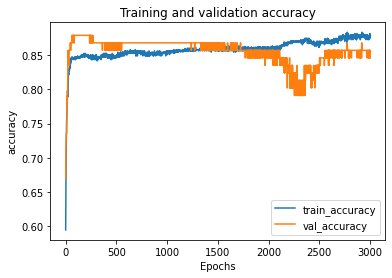

In [ ]:
plot_metric(history, 'accuracy')

In [ ]:
model.save_weights('ModelWeights')
print('Model Saved!')

Model Saved!


# Seção 3: Testando mudanças na arquitetura (questão 2)

In [ ]:
acc_exe = []

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 502/3000
9/9 [==============================] - 0s 8ms/step - loss: 0.1174 - accuracy: 0.8582 - val_loss: 0.1157 - val_accuracy: 0.8462
Epoch 503/3000
9/9 [==============================] - 0s 6ms/step - loss: 0.1174 - accuracy: 0.8582 - val_loss: 0.1155 - val_accuracy: 0.8571
Epoch 504/3000
9/9 [==============================] - 0s 7ms/step - loss: 0.1174 - accuracy: 0.8582 - val_loss: 0.1155 - val_accuracy: 0.8571
Epoch 505/3000
9/9 [==============================] - 0s 6ms/step - loss: 0.1172 - accuracy: 0.8582 - val_loss: 0.1156 - val_accuracy: 0.8571
Epoch 506/3000
9/9 [==============================] - 0s 9ms/step - loss: 0.1172 - accuracy: 0.8582 - val_loss: 0.1158 - val_accuracy: 0.8462
Epoch 507/3000
9/9 [==============================] - 0s 6ms/step - loss: 0.1171 - accuracy: 0.8582 - val_loss: 0.1157 - val_accuracy: 0.8462
Epoch 508/3000
9/9 [==============================] - 0s 7ms/step - loss: 0.1171 - accura

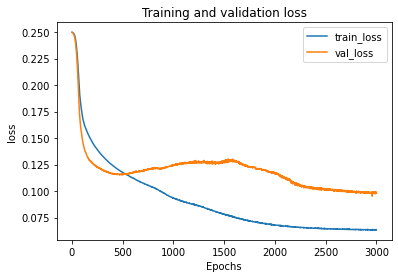

In [ ]:
class network(tf.keras.Model):

  def __init__(self):
    super(network, self).__init__()
    self.dense1 = tf.keras.layers.Dense(2, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
    self.dense3 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
    self.dense4 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
    self.dense5 = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)

  def call(self, inputs):
    x = self.dense1(inputs)
    x = self.dense2(x)
    x = self.dense3(x)
    x = self.dense4(x)
    x = self.dense5(x)
    return x

model = network()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['accuracy']) 

train_sec = x_train.iloc[:int(len(x)*0.3) :]
train_y = y_train.iloc[:int(len(x)*0.3) :]

history = model.fit(train_sec, 
                  train_y, 
                  epochs=3000,
                  validation_data=(x_val, y_val))

acc_exe.append([len(train_sec), model.evaluate(x_test, y_test)[1]])
plot_metric(history, 'loss')

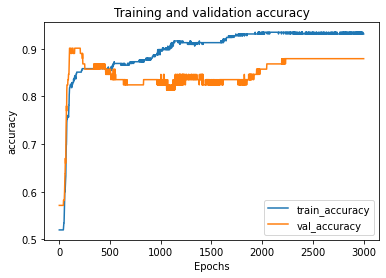

[[275, 0.8303248882293701]]


In [ ]:
plot_metric(history, 'accuracy')
print(acc_exe)

In [ ]:
model.evaluate(x_test, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 0.1990 - accuracy: 0.7798


[0.19904972612857819, 0.7797833681106567]

# Seção 4: redução dos pesos da rede (2 questão)

In [ ]:
class network_sec(tf.keras.Model):

  def __init__(self):
    super(network_sec, self).__init__()
    self.dense1 = tf.keras.layers.Dense(2, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(2, activation=tf.nn.relu)
    self.dense3 = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)

  def call(self, inputs):
    x = self.dense1(inputs)
    x = self.dense2(x)
    x = self.dense3(x)
    return x

In [ ]:
acc_weight = []

In [ ]:
model_sec = network_sec()

model_sec.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['accuracy']) 


new_trainX = x_train.iloc[:int(len(x)*(0.03)) :]
new_trainY = y_train.iloc[:int(len(x)*(0.03)) :]

history = model_sec.fit(new_trainX, 
                    new_trainY, 
                    epochs=3000,
                    validation_data=(x_val, y_val))

acc_weight.append([50, len(new_trainX), model_sec.evaluate(x_test, y_test)[1]])

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 502/3000
1/1 [==============================] - 0s 40ms/step - loss: 0.2497 - accuracy: 0.5185 - val_loss: 0.2515 - val_accuracy: 0.4615
Epoch 503/3000
1/1 [==============================] - 0s 48ms/step - loss: 0.2497 - accuracy: 0.5185 - val_loss: 0.2515 - val_accuracy: 0.4615
Epoch 504/3000
1/1 [==============================] - 0s 58ms/step - loss: 0.2497 - accuracy: 0.5185 - val_loss: 0.2515 - val_accuracy: 0.4615
Epoch 505/3000
1/1 [==============================] - 0s 57ms/step - loss: 0.2497 - accuracy: 0.5185 - val_loss: 0.2515 - val_accuracy: 0.4615
Epoch 506/3000
1/1 [==============================] - 0s 61ms/step - loss: 0.2497 - accuracy: 0.5185 - val_loss: 0.2515 - val_accuracy: 0.4615
Epoch 507/3000
1/1 [==============================] - 0s 50ms/step - loss: 0.2497 - accuracy: 0.5185 - val_loss: 0.2515 - val_accuracy: 0.4615
Epoch 508/3000
1/1 [==============================] - 0s 56ms/step - loss: 0.2497 -

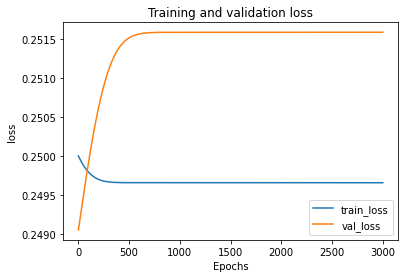

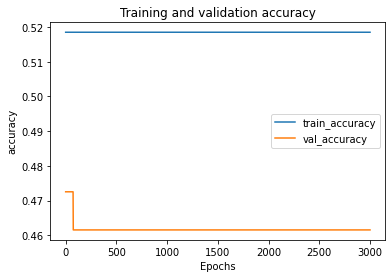

In [ ]:
plot_metric(history, 'loss')
plot_metric(history, 'accuracy')

In [ ]:
acc_weight

[[50, 27, 0.4909747242927551], [50, 27, 0.41516244411468506]]

In [ ]:
model_sec.summary()

Model: "network_sec_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             multiple                  38        
                                                                 
 dense_4 (Dense)             multiple                  6         
                                                                 
 dense_5 (Dense)             multiple                  3         
                                                                 
Total params: 47
Trainable params: 47
Non-trainable params: 0
_________________________________________________________________


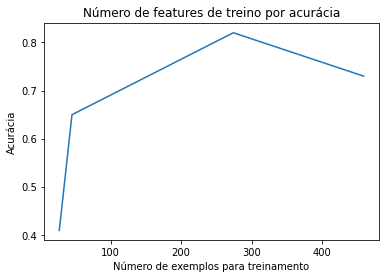

In [14]:
a = [27, 45, 274, 459]
c = [0.41, 0.65, 0.82, 0.73]

plt.title("Número de features de treino por acurácia")
plt.ylabel("Acurácia")
plt.xlabel("Número de exemplos para treinamento")
plt.plot(a, c)
plt.show()